## Imports

In [1]:
import sys 
import numpy as np 
import matplotlib.pyplot as plt


import torch
import torchvision 
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F


import models

print("Python: %s" % sys.version)
print("Pytorch: %s" % torch.__version__)

# determine device to run network on (runs on gpu if available)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Python: 3.6.5 (default, Jun 21 2018, 23:07:39) 
[GCC 5.4.0 20160609]
Pytorch: 0.4.0


## Hyperparameters

In [2]:
n_epochs = 50
batch_size = 128
lr = 0.001

## Load CIFAR10

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


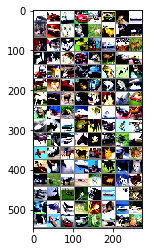

In [3]:
# define series of transforms to pre process images 
transform = torchvision.transforms.Compose([
    #torchvision.transforms.Pad(2),
    torchvision.transforms.ToTensor(),
    #torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
    

classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]


# load training set 
cifar10_trainset = torchvision.datasets.CIFAR10('datasets/', train=True, transform=transform, download=True)
cifar10_trainloader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=batch_size, shuffle=True, num_workers=2)

# load test set 
cifar10_testset = torchvision.datasets.CIFAR10('datasets/', train=False, transform=transform, download=True)
cifar10_testloader = torch.utils.data.DataLoader(cifar10_testset, batch_size=32, shuffle=False, num_workers=2)

# helper function to unnormalize and plot image 
def imshow(img):
    img = np.array(img)
    img = img / 2 + 0.5
    img = np.moveaxis(img, 0, -1)
    plt.imshow(img)
    
# display sample from dataset 
imgs,labels = iter(cifar10_trainloader).next()
imshow(torchvision.utils.make_grid(imgs))  

In [4]:
def eval_target_net(net): 
    
    class_correct = np.zeros(10)
    class_total = np.zeros(10)
    total = 0
    correct = 0
    with torch.no_grad():
        net.eval()
        for i, (imgs, lbls) in enumerate(cifar10_testloader):
            
            imgs, lbls = imgs.to(device), lbls.to(device)
            
            output = net(imgs)
            
            predicted = output.argmax(dim=1)
            
            total += imgs.size(0)
            correct += predicted.eq(lbls).sum().item()
            
            
            for prediction, lbl in zip(predicted, lbls): 
            
                class_correct[lbl] += prediction == lbl
                class_total[lbl] += 1 
            
    for i in range(10):
        print('Accuracy of %s : %.2f %%' % (classes[i], 100 * class_correct[i] / class_total[i]))
    print("\nTotal accuracy = %.2f %%\n\n" % (100*(correct/total)) )
    
def eval_attack_net(attack_net, target_net, target_train, target_out, k): 
    losses = []
    
    target_net.eval()
    attack_net.eval()

    total = 0
    correct = 0

    train_top = np.empty((0,2))
    out_top = np.empty((0,2))
    
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    
    for i, ((train_imgs, _), (out_imgs, _)) in enumerate(zip(target_train, target_out)): 


        mini_batch_size = train_imgs.shape[0]
        train_imgs, out_imgs = train_imgs.to(device), out_imgs.to(device)

        train_posteriors = F.softmax(target_net(train_imgs.detach()), dim=1)
        out_posteriors = F.softmax(target_net(out_imgs.detach()), dim=1)

        train_sort, _ = torch.sort(train_posteriors, descending=True)
        train_top_k = train_sort[:,:k].clone().to(device)

        out_sort, _ = torch.sort(out_posteriors, descending=True)
        out_top_k = out_sort[:,:k].clone().to(device)

        train_top = np.vstack((train_top,train_top_k[:,:2].cpu().detach().numpy()))
        out_top = np.vstack((out_top, out_top_k[:,:2].cpu().detach().numpy()))

        #print("train_top_k = ",train_top_k)
        #print("out_top_k = ",out_top_k)


        train_lbl = torch.ones(mini_batch_size).to(device)
        out_lbl = torch.zeros(mini_batch_size).to(device)

        
        train_predictions = torch.squeeze(attack_net(train_top_k))
        out_predictions = torch.squeeze(attack_net(out_top_k))

        #print("train_predictions = ",train_predictions)
        #print("out_predictions = ",out_predictions)
        
        
        true_positives += (train_predictions >= 0.5).sum().item()
        false_positives += (out_predictions >= 0.5).sum().item()
        false_negatives += (train_predictions < 0.5).sum().item()
        

        correct += (train_predictions>=0.5).sum().item()
        correct += (out_predictions<0.5).sum().item()
        total += train_predictions.size(0) + out_predictions.size(0)

    accuracy = 100 * correct / total
    precision = true_positives / (true_positives + false_positives) if true_positives + false_positives != 0 else 0
    recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives !=0 else 0
    print("accuracy = %.2f, precision = %.2f, recall = %.2f" % (accuracy, precision, recall))

In [5]:
from torch.utils.data.sampler import SubsetRandomSampler

total_size = len(cifar10_trainset)
split1 = total_size // 4
split2 = split1*2
split3 = split1*3

indices = list(range(total_size))

shadow_train_idx = indices[:split1]
shadow_out_idx = indices[split1:split2]
target_train_idx = indices[split2:split3]
target_out_idx = indices[split3:]


shadow_train_sampler = SubsetRandomSampler(shadow_train_idx)
shadow_out_sampler = SubsetRandomSampler(shadow_out_idx)
target_train_sampler = SubsetRandomSampler(target_train_idx)
target_out_sampler = SubsetRandomSampler(target_out_idx)

shadow_train_loader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=batch_size, sampler=shadow_train_sampler, num_workers=1)
shadow_out_loader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=batch_size, sampler=shadow_out_sampler, num_workers=1)

#attack_train_loader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=32, sampler=shadow_train_sampler, num_workers=1)

#attack_out_loader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=32, sampler=shadow_out_sampler, num_workers=1)
target_train_loader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=batch_size, sampler=target_train_sampler, num_workers=1)
target_out_loader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=batch_size, sampler=target_out_sampler, num_workers=1)


# the model being attacked (architecture can be different than shadow)
target_net = models.mlleaks_cnn().to(device)
target_net.apply(models.weights_init)

target_loss = nn.CrossEntropyLoss()
target_optim = optim.Adam(target_net.parameters(), lr=lr)


# shadow net mimics the target network (architecture can be different than target)
shadow_net = models.mlleaks_cnn().to(device)
shadow_net.apply(models.weights_init)

shadow_loss = nn.CrossEntropyLoss()
shadow_optim = optim.Adam(shadow_net.parameters(), lr=lr)


# attack net is a binary classifier to determine membership 
k = 10
attack_net = models.mlleaks_mlp(n_in=k).to(device)
attack_net.apply(models.weights_init)

#attack_loss = nn.BCEWithLogitsLoss()
attack_loss = nn.BCELoss()
attack_optim = optim.Adam(attack_net.parameters(), lr=lr)


def train(net, data_loader, optimizer, criterion, n_epochs): 
    losses = []
    for epoch in range(n_epochs): 
        net.train()
        for i, batch in enumerate(data_loader): 

            imgs, labels = batch
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = net(imgs)


            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            losses.append(loss.item())

            #print("[%d/%d][%d/%d] loss = %f" % (epoch, n_epochs, i, len(data_loader), loss.item()))

        # evaluate performance on testset at the end of each epoch 
        print("[%d/%d]" %(epoch, n_epochs))
        eval_target_net(net)

        #plt.plot(losses)
        #plt.show()

def train_attacker(attack_net, shadow_net, shadow_train, shadow_out, optimizer, criterion, n_epochs, k): 
    losses = []
    
    shadow_net.train()
    attack_net.eval()
    for epoch in range(n_epochs): 
        attack_net.train()
        total = 0
        correct = 0
        
        #train_top = np.array([])
        #train_top = []
        train_top = np.empty((0,2))
        out_top = np.empty((0,2))
        for i, ((train_imgs, _), (out_imgs, _)) in enumerate(zip(shadow_train, shadow_out)): 

            #######out_imgs = torch.randn(out_imgs.shape)
            mini_batch_size = train_imgs.shape[0]
            train_imgs, out_imgs = train_imgs.to(device), out_imgs.to(device)
            
            train_posteriors = F.softmax(shadow_net(train_imgs.detach()), dim=1)

            out_posteriors = F.softmax(shadow_net(out_imgs.detach()), dim=1)
            
            optimizer.zero_grad()
            
            train_sort, _ = torch.sort(train_posteriors, descending=True)
            train_top_k = train_sort[:,:k].clone().to(device)

            out_sort, _ = torch.sort(out_posteriors, descending=True)
            out_top_k = out_sort[:,:k].clone().to(device)
            
            train_top = np.vstack((train_top,train_top_k[:,:2].cpu().detach().numpy()))
            out_top = np.vstack((out_top, out_top_k[:,:2].cpu().detach().numpy()))
            
            #print("train_top_k = ",train_top_k)
            #print("out_top_k = ",out_top_k)
            
            
            train_lbl = torch.ones(mini_batch_size).to(device)
            out_lbl = torch.zeros(mini_batch_size).to(device)
            
            
            train_predictions = torch.squeeze(attack_net(train_top_k))
            loss_train = criterion(train_predictions, train_lbl)
            loss_train.backward()
            optimizer.step()
            
            
            
            optimizer.zero_grad()
            
            out_predictions = torch.squeeze(attack_net(out_top_k))
            loss_out = criterion(out_predictions, out_lbl)
            loss_out.backward()
            optimizer.step()
            
            #print("train_predictions = ",train_predictions)
            #print("out_predictions = ",out_predictions)
            
            
            loss = (loss_train + loss_out) / 2 
            '''
            loss_train = criterion(train_predictions, train_lbl)
            loss_out = criterion(out_predictions, out_lbl)
            loss = (loss_train + loss_out) / 2 
            loss.backward() 
            optimizer.step()
            '''
            
            
            correct += (train_predictions>=0.5).sum().item()
            correct += (out_predictions<0.5).sum().item()
            total += train_predictions.size(0) + out_predictions.size(0)
            
            
            print("[%d/%d][%d/%d] loss = %.2f, accuracy = %.2f" % (epoch, n_epochs, i, len(shadow_train), loss.item(), 100 * correct / total))
        

        '''
        plt.scatter(out_top.T[0,:], out_top.T[1,:], c='b')
        plt.scatter(train_top.T[0,:], train_top.T[1,:], c='r')
        plt.show()
        '''
        
            

        
        


In [6]:
train(shadow_net, shadow_train_loader, shadow_optim, shadow_loss, n_epochs)

[0/50]
Accuracy of airplane : 3.50 %
Accuracy of automobile : 60.30 %
Accuracy of bird : 65.20 %
Accuracy of cat : 0.20 %
Accuracy of deer : 16.90 %
Accuracy of dog : 22.40 %
Accuracy of frog : 23.60 %
Accuracy of horse : 41.70 %
Accuracy of ship : 68.60 %
Accuracy of truck : 36.90 %

Total accuracy = 33.93 %


[1/50]
Accuracy of airplane : 48.20 %
Accuracy of automobile : 34.80 %
Accuracy of bird : 35.00 %
Accuracy of cat : 26.40 %
Accuracy of deer : 36.20 %
Accuracy of dog : 45.70 %
Accuracy of frog : 40.80 %
Accuracy of horse : 68.60 %
Accuracy of ship : 67.30 %
Accuracy of truck : 48.70 %

Total accuracy = 45.17 %


[2/50]
Accuracy of airplane : 71.50 %
Accuracy of automobile : 32.50 %
Accuracy of bird : 40.00 %
Accuracy of cat : 70.40 %
Accuracy of deer : 30.50 %
Accuracy of dog : 0.80 %
Accuracy of frog : 43.30 %
Accuracy of horse : 68.60 %
Accuracy of ship : 41.60 %
Accuracy of truck : 52.00 %

Total accuracy = 45.12 %


[3/50]
Accuracy of airplane : 38.30 %
Accuracy of automobi

[26/50]
Accuracy of airplane : 80.00 %
Accuracy of automobile : 73.90 %
Accuracy of bird : 45.00 %
Accuracy of cat : 41.00 %
Accuracy of deer : 75.20 %
Accuracy of dog : 52.00 %
Accuracy of frog : 76.80 %
Accuracy of horse : 54.60 %
Accuracy of ship : 78.30 %
Accuracy of truck : 81.50 %

Total accuracy = 65.83 %


[27/50]
Accuracy of airplane : 72.60 %
Accuracy of automobile : 72.10 %
Accuracy of bird : 51.40 %
Accuracy of cat : 57.80 %
Accuracy of deer : 48.90 %
Accuracy of dog : 52.00 %
Accuracy of frog : 74.60 %
Accuracy of horse : 75.20 %
Accuracy of ship : 75.70 %
Accuracy of truck : 80.80 %

Total accuracy = 66.11 %


[28/50]
Accuracy of airplane : 58.70 %
Accuracy of automobile : 88.50 %
Accuracy of bird : 49.30 %
Accuracy of cat : 56.10 %
Accuracy of deer : 71.10 %
Accuracy of dog : 49.90 %
Accuracy of frog : 76.20 %
Accuracy of horse : 63.20 %
Accuracy of ship : 83.40 %
Accuracy of truck : 54.30 %

Total accuracy = 65.07 %


[29/50]
Accuracy of airplane : 68.30 %
Accuracy of a

In [7]:

train_attacker(attack_net, shadow_net, shadow_train_loader, shadow_out_loader, attack_optim, attack_loss, 100, k)

[0/100][0/98] loss = 0.91, accuracy = 50.00
[0/100][1/98] loss = 0.90, accuracy = 50.00
[0/100][2/98] loss = 0.88, accuracy = 50.00
[0/100][3/98] loss = 0.87, accuracy = 50.00
[0/100][4/98] loss = 0.86, accuracy = 50.00
[0/100][5/98] loss = 0.85, accuracy = 50.00
[0/100][6/98] loss = 0.84, accuracy = 50.00
[0/100][7/98] loss = 0.83, accuracy = 50.00
[0/100][8/98] loss = 0.83, accuracy = 50.00
[0/100][9/98] loss = 0.82, accuracy = 50.00
[0/100][10/98] loss = 0.81, accuracy = 50.00
[0/100][11/98] loss = 0.80, accuracy = 50.00
[0/100][12/98] loss = 0.79, accuracy = 50.00
[0/100][13/98] loss = 0.79, accuracy = 50.00
[0/100][14/98] loss = 0.78, accuracy = 50.00
[0/100][15/98] loss = 0.78, accuracy = 50.00
[0/100][16/98] loss = 0.77, accuracy = 50.00
[0/100][17/98] loss = 0.76, accuracy = 50.00
[0/100][18/98] loss = 0.76, accuracy = 50.00
[0/100][19/98] loss = 0.75, accuracy = 50.00
[0/100][20/98] loss = 0.75, accuracy = 50.00
[0/100][21/98] loss = 0.75, accuracy = 50.00
[0/100][22/98] loss 

[1/100][89/98] loss = 0.68, accuracy = 67.21
[1/100][90/98] loss = 0.68, accuracy = 67.20
[1/100][91/98] loss = 0.68, accuracy = 67.23
[1/100][92/98] loss = 0.67, accuracy = 67.23
[1/100][93/98] loss = 0.68, accuracy = 67.23
[1/100][94/98] loss = 0.67, accuracy = 67.25
[1/100][95/98] loss = 0.68, accuracy = 67.23
[1/100][96/98] loss = 0.68, accuracy = 67.23
[1/100][97/98] loss = 0.68, accuracy = 67.22
[2/100][0/98] loss = 0.68, accuracy = 66.41
[2/100][1/98] loss = 0.68, accuracy = 66.80
[2/100][2/98] loss = 0.68, accuracy = 66.41
[2/100][3/98] loss = 0.68, accuracy = 66.89
[2/100][4/98] loss = 0.68, accuracy = 66.80
[2/100][5/98] loss = 0.68, accuracy = 66.15
[2/100][6/98] loss = 0.67, accuracy = 66.52
[2/100][7/98] loss = 0.68, accuracy = 66.50
[2/100][8/98] loss = 0.68, accuracy = 66.75
[2/100][9/98] loss = 0.68, accuracy = 66.48
[2/100][10/98] loss = 0.68, accuracy = 66.30
[2/100][11/98] loss = 0.68, accuracy = 66.44
[2/100][12/98] loss = 0.68, accuracy = 66.65
[2/100][13/98] loss 

[3/100][84/98] loss = 0.67, accuracy = 66.92
[3/100][85/98] loss = 0.66, accuracy = 66.96
[3/100][86/98] loss = 0.67, accuracy = 66.95
[3/100][87/98] loss = 0.66, accuracy = 66.95
[3/100][88/98] loss = 0.67, accuracy = 66.97
[3/100][89/98] loss = 0.67, accuracy = 66.95
[3/100][90/98] loss = 0.67, accuracy = 66.96
[3/100][91/98] loss = 0.67, accuracy = 66.95
[3/100][92/98] loss = 0.66, accuracy = 66.99
[3/100][93/98] loss = 0.66, accuracy = 67.00
[3/100][94/98] loss = 0.66, accuracy = 67.01
[3/100][95/98] loss = 0.67, accuracy = 66.98
[3/100][96/98] loss = 0.66, accuracy = 66.98
[3/100][97/98] loss = 0.67, accuracy = 66.96
[4/100][0/98] loss = 0.67, accuracy = 64.06
[4/100][1/98] loss = 0.66, accuracy = 64.65
[4/100][2/98] loss = 0.67, accuracy = 65.62
[4/100][3/98] loss = 0.67, accuracy = 65.72
[4/100][4/98] loss = 0.66, accuracy = 65.55
[4/100][5/98] loss = 0.66, accuracy = 65.95
[4/100][6/98] loss = 0.67, accuracy = 65.96
[4/100][7/98] loss = 0.66, accuracy = 66.16
[4/100][8/98] loss

[5/100][72/98] loss = 0.64, accuracy = 67.05
[5/100][73/98] loss = 0.66, accuracy = 67.07
[5/100][74/98] loss = 0.66, accuracy = 67.06
[5/100][75/98] loss = 0.65, accuracy = 67.06
[5/100][76/98] loss = 0.66, accuracy = 67.04
[5/100][77/98] loss = 0.65, accuracy = 67.05
[5/100][78/98] loss = 0.66, accuracy = 67.04
[5/100][79/98] loss = 0.65, accuracy = 67.08
[5/100][80/98] loss = 0.66, accuracy = 67.08
[5/100][81/98] loss = 0.66, accuracy = 67.09
[5/100][82/98] loss = 0.66, accuracy = 67.08
[5/100][83/98] loss = 0.66, accuracy = 67.09
[5/100][84/98] loss = 0.66, accuracy = 67.10
[5/100][85/98] loss = 0.65, accuracy = 67.11
[5/100][86/98] loss = 0.66, accuracy = 67.12
[5/100][87/98] loss = 0.66, accuracy = 67.10
[5/100][88/98] loss = 0.64, accuracy = 67.15
[5/100][89/98] loss = 0.65, accuracy = 67.14
[5/100][90/98] loss = 0.65, accuracy = 67.13
[5/100][91/98] loss = 0.66, accuracy = 67.10
[5/100][92/98] loss = 0.66, accuracy = 67.06
[5/100][93/98] loss = 0.65, accuracy = 67.05
[5/100][94

[7/100][64/98] loss = 0.66, accuracy = 67.23
[7/100][65/98] loss = 0.64, accuracy = 67.23
[7/100][66/98] loss = 0.65, accuracy = 67.26
[7/100][67/98] loss = 0.65, accuracy = 67.28
[7/100][68/98] loss = 0.65, accuracy = 67.24
[7/100][69/98] loss = 0.65, accuracy = 67.22
[7/100][70/98] loss = 0.64, accuracy = 67.23
[7/100][71/98] loss = 0.66, accuracy = 67.17
[7/100][72/98] loss = 0.65, accuracy = 67.14
[7/100][73/98] loss = 0.65, accuracy = 67.16
[7/100][74/98] loss = 0.63, accuracy = 67.17
[7/100][75/98] loss = 0.65, accuracy = 67.15
[7/100][76/98] loss = 0.65, accuracy = 67.14
[7/100][77/98] loss = 0.64, accuracy = 67.17
[7/100][78/98] loss = 0.64, accuracy = 67.19
[7/100][79/98] loss = 0.65, accuracy = 67.19
[7/100][80/98] loss = 0.64, accuracy = 67.17
[7/100][81/98] loss = 0.63, accuracy = 67.19
[7/100][82/98] loss = 0.65, accuracy = 67.18
[7/100][83/98] loss = 0.63, accuracy = 67.19
[7/100][84/98] loss = 0.64, accuracy = 67.18
[7/100][85/98] loss = 0.65, accuracy = 67.17
[7/100][86

[9/100][58/98] loss = 0.65, accuracy = 67.51
[9/100][59/98] loss = 0.63, accuracy = 67.55
[9/100][60/98] loss = 0.64, accuracy = 67.53
[9/100][61/98] loss = 0.65, accuracy = 67.46
[9/100][62/98] loss = 0.63, accuracy = 67.50
[9/100][63/98] loss = 0.63, accuracy = 67.50
[9/100][64/98] loss = 0.63, accuracy = 67.57
[9/100][65/98] loss = 0.63, accuracy = 67.62
[9/100][66/98] loss = 0.65, accuracy = 67.54
[9/100][67/98] loss = 0.64, accuracy = 67.51
[9/100][68/98] loss = 0.63, accuracy = 67.53
[9/100][69/98] loss = 0.64, accuracy = 67.51
[9/100][70/98] loss = 0.65, accuracy = 67.46
[9/100][71/98] loss = 0.64, accuracy = 67.44
[9/100][72/98] loss = 0.65, accuracy = 67.39
[9/100][73/98] loss = 0.64, accuracy = 67.38
[9/100][74/98] loss = 0.62, accuracy = 67.40
[9/100][75/98] loss = 0.63, accuracy = 67.42
[9/100][76/98] loss = 0.63, accuracy = 67.47
[9/100][77/98] loss = 0.62, accuracy = 67.49
[9/100][78/98] loss = 0.64, accuracy = 67.48
[9/100][79/98] loss = 0.63, accuracy = 67.50
[9/100][80

[11/100][47/98] loss = 0.63, accuracy = 67.56
[11/100][48/98] loss = 0.64, accuracy = 67.53
[11/100][49/98] loss = 0.62, accuracy = 67.61
[11/100][50/98] loss = 0.63, accuracy = 67.62
[11/100][51/98] loss = 0.63, accuracy = 67.64
[11/100][52/98] loss = 0.64, accuracy = 67.59
[11/100][53/98] loss = 0.63, accuracy = 67.56
[11/100][54/98] loss = 0.64, accuracy = 67.49
[11/100][55/98] loss = 0.64, accuracy = 67.45
[11/100][56/98] loss = 0.61, accuracy = 67.52
[11/100][57/98] loss = 0.64, accuracy = 67.46
[11/100][58/98] loss = 0.61, accuracy = 67.50
[11/100][59/98] loss = 0.63, accuracy = 67.49
[11/100][60/98] loss = 0.64, accuracy = 67.48
[11/100][61/98] loss = 0.64, accuracy = 67.48
[11/100][62/98] loss = 0.63, accuracy = 67.48
[11/100][63/98] loss = 0.61, accuracy = 67.52
[11/100][64/98] loss = 0.65, accuracy = 67.47
[11/100][65/98] loss = 0.63, accuracy = 67.50
[11/100][66/98] loss = 0.62, accuracy = 67.53
[11/100][67/98] loss = 0.63, accuracy = 67.50
[11/100][68/98] loss = 0.63, accur

[13/100][30/98] loss = 0.61, accuracy = 68.22
[13/100][31/98] loss = 0.63, accuracy = 68.15
[13/100][32/98] loss = 0.61, accuracy = 68.18
[13/100][33/98] loss = 0.61, accuracy = 68.24
[13/100][34/98] loss = 0.60, accuracy = 68.35
[13/100][35/98] loss = 0.61, accuracy = 68.39
[13/100][36/98] loss = 0.62, accuracy = 68.37
[13/100][37/98] loss = 0.64, accuracy = 68.27
[13/100][38/98] loss = 0.61, accuracy = 68.27
[13/100][39/98] loss = 0.61, accuracy = 68.29
[13/100][40/98] loss = 0.62, accuracy = 68.25
[13/100][41/98] loss = 0.64, accuracy = 68.13
[13/100][42/98] loss = 0.63, accuracy = 68.08
[13/100][43/98] loss = 0.61, accuracy = 68.09
[13/100][44/98] loss = 0.62, accuracy = 68.10
[13/100][45/98] loss = 0.62, accuracy = 68.08
[13/100][46/98] loss = 0.60, accuracy = 68.15
[13/100][47/98] loss = 0.61, accuracy = 68.19
[13/100][48/98] loss = 0.59, accuracy = 68.28
[13/100][49/98] loss = 0.64, accuracy = 68.16
[13/100][50/98] loss = 0.63, accuracy = 68.11
[13/100][51/98] loss = 0.63, accur

[15/100][20/98] loss = 0.62, accuracy = 68.27
[15/100][21/98] loss = 0.62, accuracy = 68.29
[15/100][22/98] loss = 0.63, accuracy = 68.19
[15/100][23/98] loss = 0.61, accuracy = 68.20
[15/100][24/98] loss = 0.60, accuracy = 68.33
[15/100][25/98] loss = 0.60, accuracy = 68.42
[15/100][26/98] loss = 0.60, accuracy = 68.45
[15/100][27/98] loss = 0.62, accuracy = 68.35
[15/100][28/98] loss = 0.60, accuracy = 68.41
[15/100][29/98] loss = 0.60, accuracy = 68.45
[15/100][30/98] loss = 0.60, accuracy = 68.42
[15/100][31/98] loss = 0.62, accuracy = 68.33
[15/100][32/98] loss = 0.62, accuracy = 68.28
[15/100][33/98] loss = 0.60, accuracy = 68.32
[15/100][34/98] loss = 0.61, accuracy = 68.31
[15/100][35/98] loss = 0.63, accuracy = 68.25
[15/100][36/98] loss = 0.61, accuracy = 68.29
[15/100][37/98] loss = 0.60, accuracy = 68.31
[15/100][38/98] loss = 0.62, accuracy = 68.22
[15/100][39/98] loss = 0.60, accuracy = 68.24
[15/100][40/98] loss = 0.63, accuracy = 68.17
[15/100][41/98] loss = 0.62, accur

[17/100][9/98] loss = 0.63, accuracy = 67.50
[17/100][10/98] loss = 0.59, accuracy = 67.61
[17/100][11/98] loss = 0.60, accuracy = 67.84
[17/100][12/98] loss = 0.61, accuracy = 67.79
[17/100][13/98] loss = 0.61, accuracy = 67.77
[17/100][14/98] loss = 0.61, accuracy = 67.76
[17/100][15/98] loss = 0.62, accuracy = 67.75
[17/100][16/98] loss = 0.62, accuracy = 67.62
[17/100][17/98] loss = 0.59, accuracy = 67.66
[17/100][18/98] loss = 0.60, accuracy = 67.76
[17/100][19/98] loss = 0.60, accuracy = 67.85
[17/100][20/98] loss = 0.60, accuracy = 67.84
[17/100][21/98] loss = 0.61, accuracy = 67.74
[17/100][22/98] loss = 0.61, accuracy = 67.70
[17/100][23/98] loss = 0.62, accuracy = 67.59
[17/100][24/98] loss = 0.59, accuracy = 67.69
[17/100][25/98] loss = 0.60, accuracy = 67.77
[17/100][26/98] loss = 0.60, accuracy = 67.82
[17/100][27/98] loss = 0.59, accuracy = 67.90
[17/100][28/98] loss = 0.62, accuracy = 67.85
[17/100][29/98] loss = 0.61, accuracy = 67.81
[17/100][30/98] loss = 0.62, accura

[18/100][93/98] loss = 0.61, accuracy = 68.45
[18/100][94/98] loss = 0.62, accuracy = 68.43
[18/100][95/98] loss = 0.59, accuracy = 68.44
[18/100][96/98] loss = 0.60, accuracy = 68.45
[18/100][97/98] loss = 0.59, accuracy = 68.45
[19/100][0/98] loss = 0.59, accuracy = 67.97
[19/100][1/98] loss = 0.61, accuracy = 68.16
[19/100][2/98] loss = 0.57, accuracy = 69.79
[19/100][3/98] loss = 0.60, accuracy = 69.34
[19/100][4/98] loss = 0.61, accuracy = 68.91
[19/100][5/98] loss = 0.63, accuracy = 67.97
[19/100][6/98] loss = 0.60, accuracy = 68.42
[19/100][7/98] loss = 0.60, accuracy = 68.26
[19/100][8/98] loss = 0.59, accuracy = 68.45
[19/100][9/98] loss = 0.61, accuracy = 68.36
[19/100][10/98] loss = 0.58, accuracy = 68.50
[19/100][11/98] loss = 0.59, accuracy = 68.55
[19/100][12/98] loss = 0.60, accuracy = 68.42
[19/100][13/98] loss = 0.60, accuracy = 68.44
[19/100][14/98] loss = 0.59, accuracy = 68.65
[19/100][15/98] loss = 0.60, accuracy = 68.73
[19/100][16/98] loss = 0.59, accuracy = 68.8

[20/100][79/98] loss = 0.61, accuracy = 68.43
[20/100][80/98] loss = 0.58, accuracy = 68.47
[20/100][81/98] loss = 0.60, accuracy = 68.47
[20/100][82/98] loss = 0.59, accuracy = 68.48
[20/100][83/98] loss = 0.57, accuracy = 68.53
[20/100][84/98] loss = 0.60, accuracy = 68.54
[20/100][85/98] loss = 0.59, accuracy = 68.53
[20/100][86/98] loss = 0.63, accuracy = 68.47
[20/100][87/98] loss = 0.62, accuracy = 68.45
[20/100][88/98] loss = 0.60, accuracy = 68.45
[20/100][89/98] loss = 0.58, accuracy = 68.47
[20/100][90/98] loss = 0.57, accuracy = 68.49
[20/100][91/98] loss = 0.59, accuracy = 68.49
[20/100][92/98] loss = 0.58, accuracy = 68.50
[20/100][93/98] loss = 0.60, accuracy = 68.50
[20/100][94/98] loss = 0.58, accuracy = 68.55
[20/100][95/98] loss = 0.60, accuracy = 68.55
[20/100][96/98] loss = 0.60, accuracy = 68.53
[20/100][97/98] loss = 0.60, accuracy = 68.53
[21/100][0/98] loss = 0.60, accuracy = 66.80
[21/100][1/98] loss = 0.59, accuracy = 67.77
[21/100][2/98] loss = 0.60, accuracy

[22/100][68/98] loss = 0.59, accuracy = 68.97
[22/100][69/98] loss = 0.62, accuracy = 68.93
[22/100][70/98] loss = 0.61, accuracy = 68.89
[22/100][71/98] loss = 0.58, accuracy = 68.94
[22/100][72/98] loss = 0.57, accuracy = 68.96
[22/100][73/98] loss = 0.59, accuracy = 68.99
[22/100][74/98] loss = 0.59, accuracy = 68.99
[22/100][75/98] loss = 0.59, accuracy = 69.00
[22/100][76/98] loss = 0.59, accuracy = 69.00
[22/100][77/98] loss = 0.60, accuracy = 68.99
[22/100][78/98] loss = 0.61, accuracy = 68.95
[22/100][79/98] loss = 0.61, accuracy = 68.91
[22/100][80/98] loss = 0.59, accuracy = 68.89
[22/100][81/98] loss = 0.59, accuracy = 68.89
[22/100][82/98] loss = 0.59, accuracy = 68.89
[22/100][83/98] loss = 0.61, accuracy = 68.86
[22/100][84/98] loss = 0.57, accuracy = 68.88
[22/100][85/98] loss = 0.60, accuracy = 68.88
[22/100][86/98] loss = 0.61, accuracy = 68.85
[22/100][87/98] loss = 0.59, accuracy = 68.87
[22/100][88/98] loss = 0.58, accuracy = 68.88
[22/100][89/98] loss = 0.59, accur

[24/100][56/98] loss = 0.57, accuracy = 69.38
[24/100][57/98] loss = 0.59, accuracy = 69.37
[24/100][58/98] loss = 0.60, accuracy = 69.33
[24/100][59/98] loss = 0.57, accuracy = 69.39
[24/100][60/98] loss = 0.58, accuracy = 69.36
[24/100][61/98] loss = 0.59, accuracy = 69.35
[24/100][62/98] loss = 0.59, accuracy = 69.36
[24/100][63/98] loss = 0.58, accuracy = 69.37
[24/100][64/98] loss = 0.60, accuracy = 69.31
[24/100][65/98] loss = 0.56, accuracy = 69.35
[24/100][66/98] loss = 0.57, accuracy = 69.36
[24/100][67/98] loss = 0.62, accuracy = 69.27
[24/100][68/98] loss = 0.59, accuracy = 69.27
[24/100][69/98] loss = 0.60, accuracy = 69.25
[24/100][70/98] loss = 0.58, accuracy = 69.27
[24/100][71/98] loss = 0.58, accuracy = 69.28
[24/100][72/98] loss = 0.58, accuracy = 69.29
[24/100][73/98] loss = 0.59, accuracy = 69.29
[24/100][74/98] loss = 0.59, accuracy = 69.29
[24/100][75/98] loss = 0.60, accuracy = 69.26
[24/100][76/98] loss = 0.58, accuracy = 69.27
[24/100][77/98] loss = 0.59, accur

[26/100][39/98] loss = 0.59, accuracy = 68.63
[26/100][40/98] loss = 0.57, accuracy = 68.74
[26/100][41/98] loss = 0.58, accuracy = 68.74
[26/100][42/98] loss = 0.58, accuracy = 68.70
[26/100][43/98] loss = 0.56, accuracy = 68.79
[26/100][44/98] loss = 0.56, accuracy = 68.90
[26/100][45/98] loss = 0.57, accuracy = 68.93
[26/100][46/98] loss = 0.57, accuracy = 68.97
[26/100][47/98] loss = 0.61, accuracy = 68.89
[26/100][48/98] loss = 0.56, accuracy = 68.97
[26/100][49/98] loss = 0.59, accuracy = 68.98
[26/100][50/98] loss = 0.58, accuracy = 69.02
[26/100][51/98] loss = 0.59, accuracy = 69.02
[26/100][52/98] loss = 0.59, accuracy = 68.99
[26/100][53/98] loss = 0.58, accuracy = 68.98
[26/100][54/98] loss = 0.58, accuracy = 69.01
[26/100][55/98] loss = 0.60, accuracy = 68.99
[26/100][56/98] loss = 0.59, accuracy = 68.95
[26/100][57/98] loss = 0.58, accuracy = 68.95
[26/100][58/98] loss = 0.58, accuracy = 68.98
[26/100][59/98] loss = 0.61, accuracy = 68.91
[26/100][60/98] loss = 0.58, accur

[28/100][30/98] loss = 0.56, accuracy = 69.56
[28/100][31/98] loss = 0.59, accuracy = 69.46
[28/100][32/98] loss = 0.57, accuracy = 69.45
[28/100][33/98] loss = 0.58, accuracy = 69.43
[28/100][34/98] loss = 0.59, accuracy = 69.40
[28/100][35/98] loss = 0.56, accuracy = 69.44
[28/100][36/98] loss = 0.58, accuracy = 69.39
[28/100][37/98] loss = 0.58, accuracy = 69.35
[28/100][38/98] loss = 0.59, accuracy = 69.33
[28/100][39/98] loss = 0.58, accuracy = 69.32
[28/100][40/98] loss = 0.59, accuracy = 69.30
[28/100][41/98] loss = 0.58, accuracy = 69.31
[28/100][42/98] loss = 0.60, accuracy = 69.24
[28/100][43/98] loss = 0.57, accuracy = 69.31
[28/100][44/98] loss = 0.57, accuracy = 69.32
[28/100][45/98] loss = 0.57, accuracy = 69.31
[28/100][46/98] loss = 0.58, accuracy = 69.31
[28/100][47/98] loss = 0.58, accuracy = 69.30
[28/100][48/98] loss = 0.56, accuracy = 69.34
[28/100][49/98] loss = 0.57, accuracy = 69.37
[28/100][50/98] loss = 0.59, accuracy = 69.33
[28/100][51/98] loss = 0.60, accur

[30/100][18/98] loss = 0.55, accuracy = 69.20
[30/100][19/98] loss = 0.58, accuracy = 69.08
[30/100][20/98] loss = 0.61, accuracy = 68.88
[30/100][21/98] loss = 0.55, accuracy = 69.11
[30/100][22/98] loss = 0.55, accuracy = 69.28
[30/100][23/98] loss = 0.57, accuracy = 69.30
[30/100][24/98] loss = 0.60, accuracy = 69.20
[30/100][25/98] loss = 0.58, accuracy = 69.20
[30/100][26/98] loss = 0.56, accuracy = 69.26
[30/100][27/98] loss = 0.56, accuracy = 69.42
[30/100][28/98] loss = 0.58, accuracy = 69.37
[30/100][29/98] loss = 0.57, accuracy = 69.41
[30/100][30/98] loss = 0.60, accuracy = 69.25
[30/100][31/98] loss = 0.56, accuracy = 69.34
[30/100][32/98] loss = 0.56, accuracy = 69.38
[30/100][33/98] loss = 0.57, accuracy = 69.40
[30/100][34/98] loss = 0.58, accuracy = 69.44
[30/100][35/98] loss = 0.55, accuracy = 69.57
[30/100][36/98] loss = 0.59, accuracy = 69.55
[30/100][37/98] loss = 0.57, accuracy = 69.55
[30/100][38/98] loss = 0.58, accuracy = 69.56
[30/100][39/98] loss = 0.60, accur

[32/100][4/98] loss = 0.56, accuracy = 69.22
[32/100][5/98] loss = 0.61, accuracy = 68.49
[32/100][6/98] loss = 0.56, accuracy = 68.75
[32/100][7/98] loss = 0.57, accuracy = 68.99
[32/100][8/98] loss = 0.57, accuracy = 69.18
[32/100][9/98] loss = 0.57, accuracy = 69.22
[32/100][10/98] loss = 0.57, accuracy = 69.32
[32/100][11/98] loss = 0.57, accuracy = 69.34
[32/100][12/98] loss = 0.58, accuracy = 69.32
[32/100][13/98] loss = 0.56, accuracy = 69.34
[32/100][14/98] loss = 0.60, accuracy = 69.22
[32/100][15/98] loss = 0.57, accuracy = 69.31
[32/100][16/98] loss = 0.57, accuracy = 69.32
[32/100][17/98] loss = 0.56, accuracy = 69.40
[32/100][18/98] loss = 0.58, accuracy = 69.41
[32/100][19/98] loss = 0.56, accuracy = 69.53
[32/100][20/98] loss = 0.58, accuracy = 69.44
[32/100][21/98] loss = 0.58, accuracy = 69.44
[32/100][22/98] loss = 0.57, accuracy = 69.38
[32/100][23/98] loss = 0.57, accuracy = 69.42
[32/100][24/98] loss = 0.56, accuracy = 69.50
[32/100][25/98] loss = 0.59, accuracy = 

[33/100][89/98] loss = 0.56, accuracy = 69.77
[33/100][90/98] loss = 0.56, accuracy = 69.78
[33/100][91/98] loss = 0.57, accuracy = 69.78
[33/100][92/98] loss = 0.59, accuracy = 69.75
[33/100][93/98] loss = 0.56, accuracy = 69.76
[33/100][94/98] loss = 0.55, accuracy = 69.80
[33/100][95/98] loss = 0.54, accuracy = 69.85
[33/100][96/98] loss = 0.57, accuracy = 69.85
[33/100][97/98] loss = 0.57, accuracy = 69.86
[34/100][0/98] loss = 0.57, accuracy = 71.48
[34/100][1/98] loss = 0.55, accuracy = 72.46
[34/100][2/98] loss = 0.58, accuracy = 71.22
[34/100][3/98] loss = 0.55, accuracy = 71.78
[34/100][4/98] loss = 0.57, accuracy = 71.48
[34/100][5/98] loss = 0.57, accuracy = 71.09
[34/100][6/98] loss = 0.59, accuracy = 70.54
[34/100][7/98] loss = 0.59, accuracy = 70.31
[34/100][8/98] loss = 0.56, accuracy = 70.18
[34/100][9/98] loss = 0.57, accuracy = 70.27
[34/100][10/98] loss = 0.57, accuracy = 70.31
[34/100][11/98] loss = 0.56, accuracy = 70.41
[34/100][12/98] loss = 0.58, accuracy = 70.4

[35/100][72/98] loss = 0.56, accuracy = 70.02
[35/100][73/98] loss = 0.57, accuracy = 70.00
[35/100][74/98] loss = 0.59, accuracy = 69.98
[35/100][75/98] loss = 0.57, accuracy = 69.98
[35/100][76/98] loss = 0.57, accuracy = 69.94
[35/100][77/98] loss = 0.55, accuracy = 69.98
[35/100][78/98] loss = 0.55, accuracy = 70.03
[35/100][79/98] loss = 0.58, accuracy = 70.02
[35/100][80/98] loss = 0.56, accuracy = 70.03
[35/100][81/98] loss = 0.54, accuracy = 70.07
[35/100][82/98] loss = 0.58, accuracy = 70.04
[35/100][83/98] loss = 0.57, accuracy = 70.05
[35/100][84/98] loss = 0.59, accuracy = 70.02
[35/100][85/98] loss = 0.58, accuracy = 70.00
[35/100][86/98] loss = 0.54, accuracy = 70.02
[35/100][87/98] loss = 0.56, accuracy = 70.02
[35/100][88/98] loss = 0.54, accuracy = 70.07
[35/100][89/98] loss = 0.56, accuracy = 70.08
[35/100][90/98] loss = 0.58, accuracy = 70.07
[35/100][91/98] loss = 0.57, accuracy = 70.07
[35/100][92/98] loss = 0.56, accuracy = 70.09
[35/100][93/98] loss = 0.56, accur

[37/100][58/98] loss = 0.59, accuracy = 70.43
[37/100][59/98] loss = 0.57, accuracy = 70.42
[37/100][60/98] loss = 0.58, accuracy = 70.38
[37/100][61/98] loss = 0.58, accuracy = 70.34
[37/100][62/98] loss = 0.55, accuracy = 70.36
[37/100][63/98] loss = 0.58, accuracy = 70.32
[37/100][64/98] loss = 0.60, accuracy = 70.25
[37/100][65/98] loss = 0.59, accuracy = 70.22
[37/100][66/98] loss = 0.55, accuracy = 70.24
[37/100][67/98] loss = 0.57, accuracy = 70.25
[37/100][68/98] loss = 0.58, accuracy = 70.24
[37/100][69/98] loss = 0.56, accuracy = 70.25
[37/100][70/98] loss = 0.57, accuracy = 70.24
[37/100][71/98] loss = 0.57, accuracy = 70.23
[37/100][72/98] loss = 0.56, accuracy = 70.22
[37/100][73/98] loss = 0.56, accuracy = 70.23
[37/100][74/98] loss = 0.56, accuracy = 70.23
[37/100][75/98] loss = 0.58, accuracy = 70.21
[37/100][76/98] loss = 0.60, accuracy = 70.17
[37/100][77/98] loss = 0.55, accuracy = 70.20
[37/100][78/98] loss = 0.59, accuracy = 70.16
[37/100][79/98] loss = 0.55, accur

[39/100][47/98] loss = 0.58, accuracy = 70.57
[39/100][48/98] loss = 0.56, accuracy = 70.59
[39/100][49/98] loss = 0.55, accuracy = 70.62
[39/100][50/98] loss = 0.57, accuracy = 70.59
[39/100][51/98] loss = 0.56, accuracy = 70.57
[39/100][52/98] loss = 0.54, accuracy = 70.59
[39/100][53/98] loss = 0.55, accuracy = 70.60
[39/100][54/98] loss = 0.54, accuracy = 70.66
[39/100][55/98] loss = 0.58, accuracy = 70.61
[39/100][56/98] loss = 0.57, accuracy = 70.60
[39/100][57/98] loss = 0.56, accuracy = 70.62
[39/100][58/98] loss = 0.54, accuracy = 70.65
[39/100][59/98] loss = 0.59, accuracy = 70.59
[39/100][60/98] loss = 0.57, accuracy = 70.58
[39/100][61/98] loss = 0.59, accuracy = 70.53
[39/100][62/98] loss = 0.58, accuracy = 70.49
[39/100][63/98] loss = 0.58, accuracy = 70.45
[39/100][64/98] loss = 0.59, accuracy = 70.41
[39/100][65/98] loss = 0.56, accuracy = 70.40
[39/100][66/98] loss = 0.53, accuracy = 70.46
[39/100][67/98] loss = 0.55, accuracy = 70.46
[39/100][68/98] loss = 0.57, accur

[41/100][37/98] loss = 0.54, accuracy = 70.50
[41/100][38/98] loss = 0.55, accuracy = 70.50
[41/100][39/98] loss = 0.56, accuracy = 70.48
[41/100][40/98] loss = 0.55, accuracy = 70.49
[41/100][41/98] loss = 0.56, accuracy = 70.49
[41/100][42/98] loss = 0.54, accuracy = 70.58
[41/100][43/98] loss = 0.54, accuracy = 70.62
[41/100][44/98] loss = 0.57, accuracy = 70.59
[41/100][45/98] loss = 0.57, accuracy = 70.58
[41/100][46/98] loss = 0.59, accuracy = 70.49
[41/100][47/98] loss = 0.56, accuracy = 70.48
[41/100][48/98] loss = 0.57, accuracy = 70.42
[41/100][49/98] loss = 0.56, accuracy = 70.45
[41/100][50/98] loss = 0.55, accuracy = 70.47
[41/100][51/98] loss = 0.52, accuracy = 70.55
[41/100][52/98] loss = 0.58, accuracy = 70.48
[41/100][53/98] loss = 0.57, accuracy = 70.46
[41/100][54/98] loss = 0.58, accuracy = 70.42
[41/100][55/98] loss = 0.58, accuracy = 70.38
[41/100][56/98] loss = 0.55, accuracy = 70.39
[41/100][57/98] loss = 0.55, accuracy = 70.41
[41/100][58/98] loss = 0.54, accur

[43/100][22/98] loss = 0.54, accuracy = 70.84
[43/100][23/98] loss = 0.56, accuracy = 70.83
[43/100][24/98] loss = 0.52, accuracy = 71.03
[43/100][25/98] loss = 0.56, accuracy = 70.94
[43/100][26/98] loss = 0.55, accuracy = 70.98
[43/100][27/98] loss = 0.57, accuracy = 70.93
[43/100][28/98] loss = 0.54, accuracy = 71.00
[43/100][29/98] loss = 0.52, accuracy = 71.16
[43/100][30/98] loss = 0.56, accuracy = 71.13
[43/100][31/98] loss = 0.57, accuracy = 71.07
[43/100][32/98] loss = 0.54, accuracy = 71.15
[43/100][33/98] loss = 0.54, accuracy = 71.21
[43/100][34/98] loss = 0.57, accuracy = 71.13
[43/100][35/98] loss = 0.55, accuracy = 71.10
[43/100][36/98] loss = 0.55, accuracy = 71.09
[43/100][37/98] loss = 0.55, accuracy = 71.11
[43/100][38/98] loss = 0.56, accuracy = 71.08
[43/100][39/98] loss = 0.52, accuracy = 71.16
[43/100][40/98] loss = 0.57, accuracy = 71.07
[43/100][41/98] loss = 0.57, accuracy = 71.05
[43/100][42/98] loss = 0.55, accuracy = 71.07
[43/100][43/98] loss = 0.54, accur

[45/100][9/98] loss = 0.52, accuracy = 70.47
[45/100][10/98] loss = 0.53, accuracy = 70.70
[45/100][11/98] loss = 0.54, accuracy = 70.80
[45/100][12/98] loss = 0.54, accuracy = 70.91
[45/100][13/98] loss = 0.55, accuracy = 70.98
[45/100][14/98] loss = 0.58, accuracy = 70.83
[45/100][15/98] loss = 0.55, accuracy = 70.92
[45/100][16/98] loss = 0.51, accuracy = 71.19
[45/100][17/98] loss = 0.53, accuracy = 71.38
[45/100][18/98] loss = 0.55, accuracy = 71.36
[45/100][19/98] loss = 0.53, accuracy = 71.43
[45/100][20/98] loss = 0.57, accuracy = 71.26
[45/100][21/98] loss = 0.55, accuracy = 71.27
[45/100][22/98] loss = 0.55, accuracy = 71.28
[45/100][23/98] loss = 0.58, accuracy = 71.06
[45/100][24/98] loss = 0.55, accuracy = 71.06
[45/100][25/98] loss = 0.55, accuracy = 71.03
[45/100][26/98] loss = 0.56, accuracy = 71.04
[45/100][27/98] loss = 0.56, accuracy = 70.97
[45/100][28/98] loss = 0.53, accuracy = 71.03
[45/100][29/98] loss = 0.55, accuracy = 71.05
[45/100][30/98] loss = 0.58, accura

[47/100][0/98] loss = 0.54, accuracy = 73.44
[47/100][1/98] loss = 0.57, accuracy = 70.90
[47/100][2/98] loss = 0.55, accuracy = 70.96
[47/100][3/98] loss = 0.57, accuracy = 70.21
[47/100][4/98] loss = 0.52, accuracy = 71.09
[47/100][5/98] loss = 0.53, accuracy = 71.42
[47/100][6/98] loss = 0.55, accuracy = 71.65
[47/100][7/98] loss = 0.55, accuracy = 71.68
[47/100][8/98] loss = 0.55, accuracy = 71.53
[47/100][9/98] loss = 0.56, accuracy = 71.25
[47/100][10/98] loss = 0.54, accuracy = 71.45
[47/100][11/98] loss = 0.56, accuracy = 71.32
[47/100][12/98] loss = 0.55, accuracy = 71.24
[47/100][13/98] loss = 0.54, accuracy = 71.46
[47/100][14/98] loss = 0.55, accuracy = 71.43
[47/100][15/98] loss = 0.53, accuracy = 71.48
[47/100][16/98] loss = 0.54, accuracy = 71.48
[47/100][17/98] loss = 0.56, accuracy = 71.38
[47/100][18/98] loss = 0.52, accuracy = 71.53
[47/100][19/98] loss = 0.57, accuracy = 71.37
[47/100][20/98] loss = 0.58, accuracy = 71.24
[47/100][21/98] loss = 0.55, accuracy = 71.2

[48/100][84/98] loss = 0.53, accuracy = 71.30
[48/100][85/98] loss = 0.51, accuracy = 71.37
[48/100][86/98] loss = 0.53, accuracy = 71.39
[48/100][87/98] loss = 0.55, accuracy = 71.39
[48/100][88/98] loss = 0.56, accuracy = 71.37
[48/100][89/98] loss = 0.57, accuracy = 71.35
[48/100][90/98] loss = 0.54, accuracy = 71.36
[48/100][91/98] loss = 0.55, accuracy = 71.34
[48/100][92/98] loss = 0.55, accuracy = 71.32
[48/100][93/98] loss = 0.56, accuracy = 71.28
[48/100][94/98] loss = 0.54, accuracy = 71.30
[48/100][95/98] loss = 0.56, accuracy = 71.28
[48/100][96/98] loss = 0.54, accuracy = 71.27
[48/100][97/98] loss = 0.55, accuracy = 71.28
[49/100][0/98] loss = 0.55, accuracy = 71.09
[49/100][1/98] loss = 0.55, accuracy = 71.68
[49/100][2/98] loss = 0.57, accuracy = 70.96
[49/100][3/98] loss = 0.56, accuracy = 70.80
[49/100][4/98] loss = 0.57, accuracy = 70.78
[49/100][5/98] loss = 0.51, accuracy = 71.74
[49/100][6/98] loss = 0.56, accuracy = 71.71
[49/100][7/98] loss = 0.57, accuracy = 71

[50/100][69/98] loss = 0.57, accuracy = 71.34
[50/100][70/98] loss = 0.57, accuracy = 71.31
[50/100][71/98] loss = 0.54, accuracy = 71.33
[50/100][72/98] loss = 0.55, accuracy = 71.33
[50/100][73/98] loss = 0.54, accuracy = 71.35
[50/100][74/98] loss = 0.57, accuracy = 71.31
[50/100][75/98] loss = 0.55, accuracy = 71.31
[50/100][76/98] loss = 0.52, accuracy = 71.36
[50/100][77/98] loss = 0.53, accuracy = 71.38
[50/100][78/98] loss = 0.54, accuracy = 71.40
[50/100][79/98] loss = 0.56, accuracy = 71.39
[50/100][80/98] loss = 0.53, accuracy = 71.42
[50/100][81/98] loss = 0.53, accuracy = 71.45
[50/100][82/98] loss = 0.54, accuracy = 71.47
[50/100][83/98] loss = 0.54, accuracy = 71.47
[50/100][84/98] loss = 0.54, accuracy = 71.48
[50/100][85/98] loss = 0.55, accuracy = 71.46
[50/100][86/98] loss = 0.54, accuracy = 71.45
[50/100][87/98] loss = 0.55, accuracy = 71.42
[50/100][88/98] loss = 0.52, accuracy = 71.47
[50/100][89/98] loss = 0.57, accuracy = 71.43
[50/100][90/98] loss = 0.55, accur

[52/100][52/98] loss = 0.54, accuracy = 71.33
[52/100][53/98] loss = 0.55, accuracy = 71.36
[52/100][54/98] loss = 0.55, accuracy = 71.36
[52/100][55/98] loss = 0.55, accuracy = 71.34
[52/100][56/98] loss = 0.56, accuracy = 71.33
[52/100][57/98] loss = 0.52, accuracy = 71.37
[52/100][58/98] loss = 0.54, accuracy = 71.37
[52/100][59/98] loss = 0.56, accuracy = 71.34
[52/100][60/98] loss = 0.55, accuracy = 71.36
[52/100][61/98] loss = 0.53, accuracy = 71.38
[52/100][62/98] loss = 0.56, accuracy = 71.33
[52/100][63/98] loss = 0.56, accuracy = 71.33
[52/100][64/98] loss = 0.56, accuracy = 71.29
[52/100][65/98] loss = 0.51, accuracy = 71.34
[52/100][66/98] loss = 0.51, accuracy = 71.41
[52/100][67/98] loss = 0.56, accuracy = 71.40
[52/100][68/98] loss = 0.55, accuracy = 71.38
[52/100][69/98] loss = 0.58, accuracy = 71.30
[52/100][70/98] loss = 0.56, accuracy = 71.29
[52/100][71/98] loss = 0.55, accuracy = 71.27
[52/100][72/98] loss = 0.55, accuracy = 71.27
[52/100][73/98] loss = 0.53, accur

[54/100][36/98] loss = 0.53, accuracy = 71.78
[54/100][37/98] loss = 0.57, accuracy = 71.68
[54/100][38/98] loss = 0.56, accuracy = 71.61
[54/100][39/98] loss = 0.53, accuracy = 71.69
[54/100][40/98] loss = 0.54, accuracy = 71.67
[54/100][41/98] loss = 0.53, accuracy = 71.71
[54/100][42/98] loss = 0.55, accuracy = 71.72
[54/100][43/98] loss = 0.56, accuracy = 71.64
[54/100][44/98] loss = 0.51, accuracy = 71.72
[54/100][45/98] loss = 0.55, accuracy = 71.71
[54/100][46/98] loss = 0.55, accuracy = 71.70
[54/100][47/98] loss = 0.53, accuracy = 71.73
[54/100][48/98] loss = 0.52, accuracy = 71.82
[54/100][49/98] loss = 0.53, accuracy = 71.80
[54/100][50/98] loss = 0.54, accuracy = 71.83
[54/100][51/98] loss = 0.56, accuracy = 71.79
[54/100][52/98] loss = 0.54, accuracy = 71.82
[54/100][53/98] loss = 0.53, accuracy = 71.85
[54/100][54/98] loss = 0.53, accuracy = 71.88
[54/100][55/98] loss = 0.57, accuracy = 71.83
[54/100][56/98] loss = 0.54, accuracy = 71.85
[54/100][57/98] loss = 0.57, accur

[56/100][19/98] loss = 0.55, accuracy = 71.54
[56/100][20/98] loss = 0.58, accuracy = 71.28
[56/100][21/98] loss = 0.51, accuracy = 71.43
[56/100][22/98] loss = 0.58, accuracy = 71.26
[56/100][23/98] loss = 0.53, accuracy = 71.32
[56/100][24/98] loss = 0.56, accuracy = 71.36
[56/100][25/98] loss = 0.56, accuracy = 71.29
[56/100][26/98] loss = 0.54, accuracy = 71.34
[56/100][27/98] loss = 0.54, accuracy = 71.37
[56/100][28/98] loss = 0.55, accuracy = 71.38
[56/100][29/98] loss = 0.49, accuracy = 71.61
[56/100][30/98] loss = 0.55, accuracy = 71.60
[56/100][31/98] loss = 0.54, accuracy = 71.59
[56/100][32/98] loss = 0.56, accuracy = 71.58
[56/100][33/98] loss = 0.55, accuracy = 71.56
[56/100][34/98] loss = 0.53, accuracy = 71.58
[56/100][35/98] loss = 0.55, accuracy = 71.57
[56/100][36/98] loss = 0.51, accuracy = 71.70
[56/100][37/98] loss = 0.55, accuracy = 71.64
[56/100][38/98] loss = 0.57, accuracy = 71.54
[56/100][39/98] loss = 0.51, accuracy = 71.65
[56/100][40/98] loss = 0.51, accur

[58/100][10/98] loss = 0.51, accuracy = 71.41
[58/100][11/98] loss = 0.51, accuracy = 71.71
[58/100][12/98] loss = 0.53, accuracy = 71.75
[58/100][13/98] loss = 0.51, accuracy = 71.93
[58/100][14/98] loss = 0.55, accuracy = 71.88
[58/100][15/98] loss = 0.50, accuracy = 72.19
[58/100][16/98] loss = 0.56, accuracy = 72.06
[58/100][17/98] loss = 0.55, accuracy = 71.92
[58/100][18/98] loss = 0.55, accuracy = 71.85
[58/100][19/98] loss = 0.52, accuracy = 71.99
[58/100][20/98] loss = 0.56, accuracy = 71.93
[58/100][21/98] loss = 0.53, accuracy = 71.95
[58/100][22/98] loss = 0.56, accuracy = 71.84
[58/100][23/98] loss = 0.55, accuracy = 71.81
[58/100][24/98] loss = 0.54, accuracy = 71.80
[58/100][25/98] loss = 0.55, accuracy = 71.75
[58/100][26/98] loss = 0.55, accuracy = 71.67
[58/100][27/98] loss = 0.53, accuracy = 71.69
[58/100][28/98] loss = 0.55, accuracy = 71.69
[58/100][29/98] loss = 0.53, accuracy = 71.72
[58/100][30/98] loss = 0.49, accuracy = 71.88
[58/100][31/98] loss = 0.55, accur

[59/100][95/98] loss = 0.57, accuracy = 71.75
[59/100][96/98] loss = 0.54, accuracy = 71.75
[59/100][97/98] loss = 0.55, accuracy = 71.74
[60/100][0/98] loss = 0.55, accuracy = 69.14
[60/100][1/98] loss = 0.55, accuracy = 69.53
[60/100][2/98] loss = 0.55, accuracy = 69.79
[60/100][3/98] loss = 0.55, accuracy = 70.21
[60/100][4/98] loss = 0.53, accuracy = 70.55
[60/100][5/98] loss = 0.55, accuracy = 70.57
[60/100][6/98] loss = 0.54, accuracy = 70.76
[60/100][7/98] loss = 0.54, accuracy = 70.80
[60/100][8/98] loss = 0.51, accuracy = 71.40
[60/100][9/98] loss = 0.58, accuracy = 70.94
[60/100][10/98] loss = 0.53, accuracy = 71.13
[60/100][11/98] loss = 0.55, accuracy = 71.09
[60/100][12/98] loss = 0.56, accuracy = 70.85
[60/100][13/98] loss = 0.59, accuracy = 70.51
[60/100][14/98] loss = 0.51, accuracy = 70.86
[60/100][15/98] loss = 0.55, accuracy = 70.87
[60/100][16/98] loss = 0.53, accuracy = 71.02
[60/100][17/98] loss = 0.52, accuracy = 71.18
[60/100][18/98] loss = 0.56, accuracy = 71.0

[61/100][81/98] loss = 0.54, accuracy = 71.99
[61/100][82/98] loss = 0.55, accuracy = 71.99
[61/100][83/98] loss = 0.52, accuracy = 72.02
[61/100][84/98] loss = 0.52, accuracy = 72.05
[61/100][85/98] loss = 0.54, accuracy = 72.07
[61/100][86/98] loss = 0.55, accuracy = 72.05
[61/100][87/98] loss = 0.52, accuracy = 72.08
[61/100][88/98] loss = 0.53, accuracy = 72.08
[61/100][89/98] loss = 0.52, accuracy = 72.09
[61/100][90/98] loss = 0.52, accuracy = 72.10
[61/100][91/98] loss = 0.57, accuracy = 72.07
[61/100][92/98] loss = 0.54, accuracy = 72.06
[61/100][93/98] loss = 0.53, accuracy = 72.07
[61/100][94/98] loss = 0.57, accuracy = 72.04
[61/100][95/98] loss = 0.52, accuracy = 72.07
[61/100][96/98] loss = 0.53, accuracy = 72.07
[61/100][97/98] loss = 0.55, accuracy = 72.06
[62/100][0/98] loss = 0.57, accuracy = 68.36
[62/100][1/98] loss = 0.50, accuracy = 72.27
[62/100][2/98] loss = 0.54, accuracy = 72.40
[62/100][3/98] loss = 0.53, accuracy = 72.27
[62/100][4/98] loss = 0.54, accuracy =

[63/100][71/98] loss = 0.55, accuracy = 72.15
[63/100][72/98] loss = 0.57, accuracy = 72.12
[63/100][73/98] loss = 0.55, accuracy = 72.10
[63/100][74/98] loss = 0.53, accuracy = 72.11
[63/100][75/98] loss = 0.51, accuracy = 72.14
[63/100][76/98] loss = 0.56, accuracy = 72.10
[63/100][77/98] loss = 0.55, accuracy = 72.10
[63/100][78/98] loss = 0.54, accuracy = 72.08
[63/100][79/98] loss = 0.54, accuracy = 72.08
[63/100][80/98] loss = 0.53, accuracy = 72.09
[63/100][81/98] loss = 0.55, accuracy = 72.08
[63/100][82/98] loss = 0.52, accuracy = 72.09
[63/100][83/98] loss = 0.55, accuracy = 72.07
[63/100][84/98] loss = 0.53, accuracy = 72.07
[63/100][85/98] loss = 0.55, accuracy = 72.06
[63/100][86/98] loss = 0.53, accuracy = 72.06
[63/100][87/98] loss = 0.53, accuracy = 72.07
[63/100][88/98] loss = 0.53, accuracy = 72.08
[63/100][89/98] loss = 0.53, accuracy = 72.10
[63/100][90/98] loss = 0.54, accuracy = 72.11
[63/100][91/98] loss = 0.56, accuracy = 72.10
[63/100][92/98] loss = 0.56, accur

[65/100][60/98] loss = 0.50, accuracy = 72.11
[65/100][61/98] loss = 0.53, accuracy = 72.13
[65/100][62/98] loss = 0.55, accuracy = 72.12
[65/100][63/98] loss = 0.55, accuracy = 72.08
[65/100][64/98] loss = 0.55, accuracy = 72.06
[65/100][65/98] loss = 0.54, accuracy = 72.05
[65/100][66/98] loss = 0.54, accuracy = 72.04
[65/100][67/98] loss = 0.55, accuracy = 72.00
[65/100][68/98] loss = 0.55, accuracy = 71.96
[65/100][69/98] loss = 0.54, accuracy = 71.97
[65/100][70/98] loss = 0.54, accuracy = 71.97
[65/100][71/98] loss = 0.53, accuracy = 71.99
[65/100][72/98] loss = 0.53, accuracy = 71.99
[65/100][73/98] loss = 0.56, accuracy = 71.95
[65/100][74/98] loss = 0.50, accuracy = 72.02
[65/100][75/98] loss = 0.56, accuracy = 71.97
[65/100][76/98] loss = 0.53, accuracy = 71.98
[65/100][77/98] loss = 0.58, accuracy = 71.93
[65/100][78/98] loss = 0.50, accuracy = 71.97
[65/100][79/98] loss = 0.53, accuracy = 71.99
[65/100][80/98] loss = 0.54, accuracy = 71.98
[65/100][81/98] loss = 0.52, accur

[67/100][48/98] loss = 0.50, accuracy = 72.22
[67/100][49/98] loss = 0.55, accuracy = 72.20
[67/100][50/98] loss = 0.54, accuracy = 72.18
[67/100][51/98] loss = 0.54, accuracy = 72.18
[67/100][52/98] loss = 0.56, accuracy = 72.12
[67/100][53/98] loss = 0.51, accuracy = 72.17
[67/100][54/98] loss = 0.54, accuracy = 72.17
[67/100][55/98] loss = 0.56, accuracy = 72.12
[67/100][56/98] loss = 0.54, accuracy = 72.11
[67/100][57/98] loss = 0.56, accuracy = 72.07
[67/100][58/98] loss = 0.49, accuracy = 72.17
[67/100][59/98] loss = 0.52, accuracy = 72.20
[67/100][60/98] loss = 0.50, accuracy = 72.26
[67/100][61/98] loss = 0.54, accuracy = 72.25
[67/100][62/98] loss = 0.51, accuracy = 72.32
[67/100][63/98] loss = 0.53, accuracy = 72.31
[67/100][64/98] loss = 0.54, accuracy = 72.31
[67/100][65/98] loss = 0.51, accuracy = 72.35
[67/100][66/98] loss = 0.54, accuracy = 72.34
[67/100][67/98] loss = 0.51, accuracy = 72.36
[67/100][68/98] loss = 0.52, accuracy = 72.39
[67/100][69/98] loss = 0.53, accur

[69/100][37/98] loss = 0.51, accuracy = 72.10
[69/100][38/98] loss = 0.54, accuracy = 72.10
[69/100][39/98] loss = 0.52, accuracy = 72.11
[69/100][40/98] loss = 0.55, accuracy = 72.07
[69/100][41/98] loss = 0.53, accuracy = 72.07
[69/100][42/98] loss = 0.53, accuracy = 72.05
[69/100][43/98] loss = 0.57, accuracy = 72.01
[69/100][44/98] loss = 0.51, accuracy = 72.07
[69/100][45/98] loss = 0.53, accuracy = 72.09
[69/100][46/98] loss = 0.55, accuracy = 72.06
[69/100][47/98] loss = 0.52, accuracy = 72.08
[69/100][48/98] loss = 0.54, accuracy = 72.07
[69/100][49/98] loss = 0.53, accuracy = 72.08
[69/100][50/98] loss = 0.52, accuracy = 72.15
[69/100][51/98] loss = 0.50, accuracy = 72.24
[69/100][52/98] loss = 0.50, accuracy = 72.32
[69/100][53/98] loss = 0.54, accuracy = 72.28
[69/100][54/98] loss = 0.55, accuracy = 72.26
[69/100][55/98] loss = 0.55, accuracy = 72.24
[69/100][56/98] loss = 0.54, accuracy = 72.24
[69/100][57/98] loss = 0.50, accuracy = 72.31
[69/100][58/98] loss = 0.52, accur

[71/100][20/98] loss = 0.53, accuracy = 72.88
[71/100][21/98] loss = 0.51, accuracy = 72.89
[71/100][22/98] loss = 0.53, accuracy = 72.93
[71/100][23/98] loss = 0.50, accuracy = 73.03
[71/100][24/98] loss = 0.54, accuracy = 73.02
[71/100][25/98] loss = 0.55, accuracy = 72.84
[71/100][26/98] loss = 0.52, accuracy = 72.93
[71/100][27/98] loss = 0.51, accuracy = 73.03
[71/100][28/98] loss = 0.51, accuracy = 73.14
[71/100][29/98] loss = 0.50, accuracy = 73.19
[71/100][30/98] loss = 0.53, accuracy = 73.19
[71/100][31/98] loss = 0.57, accuracy = 73.07
[71/100][32/98] loss = 0.53, accuracy = 73.04
[71/100][33/98] loss = 0.53, accuracy = 73.00
[71/100][34/98] loss = 0.53, accuracy = 72.97
[71/100][35/98] loss = 0.55, accuracy = 72.92
[71/100][36/98] loss = 0.52, accuracy = 72.92
[71/100][37/98] loss = 0.54, accuracy = 72.86
[71/100][38/98] loss = 0.51, accuracy = 72.86
[71/100][39/98] loss = 0.54, accuracy = 72.77
[71/100][40/98] loss = 0.55, accuracy = 72.72
[71/100][41/98] loss = 0.53, accur

[73/100][4/98] loss = 0.54, accuracy = 72.58
[73/100][5/98] loss = 0.53, accuracy = 72.66
[73/100][6/98] loss = 0.53, accuracy = 72.32
[73/100][7/98] loss = 0.55, accuracy = 71.83
[73/100][8/98] loss = 0.53, accuracy = 72.05
[73/100][9/98] loss = 0.52, accuracy = 72.27
[73/100][10/98] loss = 0.50, accuracy = 72.37
[73/100][11/98] loss = 0.54, accuracy = 72.30
[73/100][12/98] loss = 0.51, accuracy = 72.51
[73/100][13/98] loss = 0.51, accuracy = 72.71
[73/100][14/98] loss = 0.51, accuracy = 72.81
[73/100][15/98] loss = 0.49, accuracy = 72.95
[73/100][16/98] loss = 0.54, accuracy = 72.84
[73/100][17/98] loss = 0.56, accuracy = 72.63
[73/100][18/98] loss = 0.51, accuracy = 72.74
[73/100][19/98] loss = 0.56, accuracy = 72.58
[73/100][20/98] loss = 0.54, accuracy = 72.54
[73/100][21/98] loss = 0.51, accuracy = 72.66
[73/100][22/98] loss = 0.52, accuracy = 72.69
[73/100][23/98] loss = 0.54, accuracy = 72.64
[73/100][24/98] loss = 0.54, accuracy = 72.59
[73/100][25/98] loss = 0.56, accuracy = 

[74/100][89/98] loss = 0.53, accuracy = 72.67
[74/100][90/98] loss = 0.54, accuracy = 72.66
[74/100][91/98] loss = 0.53, accuracy = 72.66
[74/100][92/98] loss = 0.53, accuracy = 72.67
[74/100][93/98] loss = 0.55, accuracy = 72.64
[74/100][94/98] loss = 0.55, accuracy = 72.62
[74/100][95/98] loss = 0.55, accuracy = 72.59
[74/100][96/98] loss = 0.51, accuracy = 72.62
[74/100][97/98] loss = 0.55, accuracy = 72.60
[75/100][0/98] loss = 0.54, accuracy = 71.09
[75/100][1/98] loss = 0.53, accuracy = 71.88
[75/100][2/98] loss = 0.55, accuracy = 70.96
[75/100][3/98] loss = 0.52, accuracy = 71.78
[75/100][4/98] loss = 0.53, accuracy = 71.80
[75/100][5/98] loss = 0.52, accuracy = 72.27
[75/100][6/98] loss = 0.54, accuracy = 72.15
[75/100][7/98] loss = 0.55, accuracy = 71.78
[75/100][8/98] loss = 0.54, accuracy = 71.74
[75/100][9/98] loss = 0.51, accuracy = 71.95
[75/100][10/98] loss = 0.52, accuracy = 72.12
[75/100][11/98] loss = 0.49, accuracy = 72.56
[75/100][12/98] loss = 0.54, accuracy = 72.5

[76/100][72/98] loss = 0.51, accuracy = 72.77
[76/100][73/98] loss = 0.56, accuracy = 72.74
[76/100][74/98] loss = 0.53, accuracy = 72.71
[76/100][75/98] loss = 0.54, accuracy = 72.71
[76/100][76/98] loss = 0.53, accuracy = 72.71
[76/100][77/98] loss = 0.54, accuracy = 72.71
[76/100][78/98] loss = 0.52, accuracy = 72.70
[76/100][79/98] loss = 0.52, accuracy = 72.71
[76/100][80/98] loss = 0.51, accuracy = 72.73
[76/100][81/98] loss = 0.51, accuracy = 72.75
[76/100][82/98] loss = 0.54, accuracy = 72.72
[76/100][83/98] loss = 0.53, accuracy = 72.72
[76/100][84/98] loss = 0.53, accuracy = 72.73
[76/100][85/98] loss = 0.56, accuracy = 72.66
[76/100][86/98] loss = 0.56, accuracy = 72.62
[76/100][87/98] loss = 0.51, accuracy = 72.63
[76/100][88/98] loss = 0.52, accuracy = 72.63
[76/100][89/98] loss = 0.52, accuracy = 72.64
[76/100][90/98] loss = 0.53, accuracy = 72.63
[76/100][91/98] loss = 0.53, accuracy = 72.62
[76/100][92/98] loss = 0.54, accuracy = 72.61
[76/100][93/98] loss = 0.48, accur

[78/100][63/98] loss = 0.53, accuracy = 72.66
[78/100][64/98] loss = 0.53, accuracy = 72.64
[78/100][65/98] loss = 0.54, accuracy = 72.62
[78/100][66/98] loss = 0.53, accuracy = 72.62
[78/100][67/98] loss = 0.51, accuracy = 72.64
[78/100][68/98] loss = 0.54, accuracy = 72.62
[78/100][69/98] loss = 0.50, accuracy = 72.68
[78/100][70/98] loss = 0.51, accuracy = 72.70
[78/100][71/98] loss = 0.55, accuracy = 72.66
[78/100][72/98] loss = 0.51, accuracy = 72.67
[78/100][73/98] loss = 0.52, accuracy = 72.66
[78/100][74/98] loss = 0.51, accuracy = 72.69
[78/100][75/98] loss = 0.52, accuracy = 72.71
[78/100][76/98] loss = 0.54, accuracy = 72.68
[78/100][77/98] loss = 0.54, accuracy = 72.68
[78/100][78/98] loss = 0.51, accuracy = 72.71
[78/100][79/98] loss = 0.57, accuracy = 72.66
[78/100][80/98] loss = 0.53, accuracy = 72.65
[78/100][81/98] loss = 0.51, accuracy = 72.68
[78/100][82/98] loss = 0.53, accuracy = 72.67
[78/100][83/98] loss = 0.51, accuracy = 72.71
[78/100][84/98] loss = 0.52, accur

[80/100][50/98] loss = 0.55, accuracy = 73.21
[80/100][51/98] loss = 0.52, accuracy = 73.20
[80/100][52/98] loss = 0.53, accuracy = 73.21
[80/100][53/98] loss = 0.52, accuracy = 73.21
[80/100][54/98] loss = 0.52, accuracy = 73.20
[80/100][55/98] loss = 0.52, accuracy = 73.20
[80/100][56/98] loss = 0.55, accuracy = 73.14
[80/100][57/98] loss = 0.54, accuracy = 73.12
[80/100][58/98] loss = 0.52, accuracy = 73.13
[80/100][59/98] loss = 0.52, accuracy = 73.12
[80/100][60/98] loss = 0.51, accuracy = 73.15
[80/100][61/98] loss = 0.53, accuracy = 73.14
[80/100][62/98] loss = 0.57, accuracy = 73.05
[80/100][63/98] loss = 0.55, accuracy = 73.00
[80/100][64/98] loss = 0.55, accuracy = 72.96
[80/100][65/98] loss = 0.55, accuracy = 72.90
[80/100][66/98] loss = 0.52, accuracy = 72.90
[80/100][67/98] loss = 0.51, accuracy = 72.93
[80/100][68/98] loss = 0.51, accuracy = 72.96
[80/100][69/98] loss = 0.51, accuracy = 72.98
[80/100][70/98] loss = 0.49, accuracy = 73.04
[80/100][71/98] loss = 0.51, accur

[82/100][40/98] loss = 0.52, accuracy = 72.61
[82/100][41/98] loss = 0.53, accuracy = 72.62
[82/100][42/98] loss = 0.50, accuracy = 72.68
[82/100][43/98] loss = 0.53, accuracy = 72.67
[82/100][44/98] loss = 0.54, accuracy = 72.61
[82/100][45/98] loss = 0.55, accuracy = 72.56
[82/100][46/98] loss = 0.52, accuracy = 72.60
[82/100][47/98] loss = 0.53, accuracy = 72.62
[82/100][48/98] loss = 0.51, accuracy = 72.65
[82/100][49/98] loss = 0.52, accuracy = 72.66
[82/100][50/98] loss = 0.49, accuracy = 72.73
[82/100][51/98] loss = 0.51, accuracy = 72.74
[82/100][52/98] loss = 0.53, accuracy = 72.74
[82/100][53/98] loss = 0.53, accuracy = 72.74
[82/100][54/98] loss = 0.50, accuracy = 72.80
[82/100][55/98] loss = 0.52, accuracy = 72.81
[82/100][56/98] loss = 0.52, accuracy = 72.85
[82/100][57/98] loss = 0.50, accuracy = 72.92
[82/100][58/98] loss = 0.52, accuracy = 72.93
[82/100][59/98] loss = 0.52, accuracy = 72.95
[82/100][60/98] loss = 0.52, accuracy = 72.95
[82/100][61/98] loss = 0.54, accur

[84/100][27/98] loss = 0.53, accuracy = 72.42
[84/100][28/98] loss = 0.50, accuracy = 72.52
[84/100][29/98] loss = 0.51, accuracy = 72.58
[84/100][30/98] loss = 0.54, accuracy = 72.52
[84/100][31/98] loss = 0.56, accuracy = 72.42
[84/100][32/98] loss = 0.50, accuracy = 72.53
[84/100][33/98] loss = 0.50, accuracy = 72.60
[84/100][34/98] loss = 0.49, accuracy = 72.70
[84/100][35/98] loss = 0.52, accuracy = 72.72
[84/100][36/98] loss = 0.53, accuracy = 72.69
[84/100][37/98] loss = 0.54, accuracy = 72.65
[84/100][38/98] loss = 0.50, accuracy = 72.73
[84/100][39/98] loss = 0.53, accuracy = 72.72
[84/100][40/98] loss = 0.53, accuracy = 72.73
[84/100][41/98] loss = 0.52, accuracy = 72.76
[84/100][42/98] loss = 0.56, accuracy = 72.69
[84/100][43/98] loss = 0.54, accuracy = 72.65
[84/100][44/98] loss = 0.50, accuracy = 72.69
[84/100][45/98] loss = 0.55, accuracy = 72.61
[84/100][46/98] loss = 0.50, accuracy = 72.66
[84/100][47/98] loss = 0.50, accuracy = 72.76
[84/100][48/98] loss = 0.50, accur

[86/100][11/98] loss = 0.50, accuracy = 73.73
[86/100][12/98] loss = 0.52, accuracy = 73.56
[86/100][13/98] loss = 0.52, accuracy = 73.52
[86/100][14/98] loss = 0.52, accuracy = 73.44
[86/100][15/98] loss = 0.53, accuracy = 73.39
[86/100][16/98] loss = 0.54, accuracy = 73.25
[86/100][17/98] loss = 0.53, accuracy = 73.26
[86/100][18/98] loss = 0.56, accuracy = 73.01
[86/100][19/98] loss = 0.53, accuracy = 73.01
[86/100][20/98] loss = 0.51, accuracy = 73.10
[86/100][21/98] loss = 0.53, accuracy = 73.03
[86/100][22/98] loss = 0.56, accuracy = 72.86
[86/100][23/98] loss = 0.52, accuracy = 72.90
[86/100][24/98] loss = 0.53, accuracy = 72.84
[86/100][25/98] loss = 0.50, accuracy = 72.97
[86/100][26/98] loss = 0.54, accuracy = 72.90
[86/100][27/98] loss = 0.48, accuracy = 72.98
[86/100][28/98] loss = 0.52, accuracy = 72.98
[86/100][29/98] loss = 0.51, accuracy = 73.01
[86/100][30/98] loss = 0.55, accuracy = 72.96
[86/100][31/98] loss = 0.52, accuracy = 72.94
[86/100][32/98] loss = 0.54, accur

[87/100][93/98] loss = 0.49, accuracy = 73.11
[87/100][94/98] loss = 0.50, accuracy = 73.12
[87/100][95/98] loss = 0.53, accuracy = 73.12
[87/100][96/98] loss = 0.53, accuracy = 73.09
[87/100][97/98] loss = 0.53, accuracy = 73.08
[88/100][0/98] loss = 0.52, accuracy = 73.44
[88/100][1/98] loss = 0.51, accuracy = 74.41
[88/100][2/98] loss = 0.54, accuracy = 73.05
[88/100][3/98] loss = 0.55, accuracy = 72.27
[88/100][4/98] loss = 0.53, accuracy = 72.42
[88/100][5/98] loss = 0.51, accuracy = 72.72
[88/100][6/98] loss = 0.52, accuracy = 72.77
[88/100][7/98] loss = 0.49, accuracy = 73.00
[88/100][8/98] loss = 0.51, accuracy = 73.18
[88/100][9/98] loss = 0.54, accuracy = 72.93
[88/100][10/98] loss = 0.53, accuracy = 72.80
[88/100][11/98] loss = 0.53, accuracy = 72.75
[88/100][12/98] loss = 0.52, accuracy = 72.72
[88/100][13/98] loss = 0.52, accuracy = 72.77
[88/100][14/98] loss = 0.52, accuracy = 72.86
[88/100][15/98] loss = 0.51, accuracy = 72.90
[88/100][16/98] loss = 0.53, accuracy = 72.8

[89/100][79/98] loss = 0.53, accuracy = 73.13
[89/100][80/98] loss = 0.52, accuracy = 73.12
[89/100][81/98] loss = 0.55, accuracy = 73.09
[89/100][82/98] loss = 0.51, accuracy = 73.12
[89/100][83/98] loss = 0.50, accuracy = 73.16
[89/100][84/98] loss = 0.52, accuracy = 73.17
[89/100][85/98] loss = 0.45, accuracy = 73.24
[89/100][86/98] loss = 0.51, accuracy = 73.26
[89/100][87/98] loss = 0.55, accuracy = 73.24
[89/100][88/98] loss = 0.49, accuracy = 73.26
[89/100][89/98] loss = 0.55, accuracy = 73.24
[89/100][90/98] loss = 0.53, accuracy = 73.21
[89/100][91/98] loss = 0.51, accuracy = 73.21
[89/100][92/98] loss = 0.52, accuracy = 73.21
[89/100][93/98] loss = 0.55, accuracy = 73.17
[89/100][94/98] loss = 0.56, accuracy = 73.12
[89/100][95/98] loss = 0.50, accuracy = 73.14
[89/100][96/98] loss = 0.49, accuracy = 73.17
[89/100][97/98] loss = 0.53, accuracy = 73.16
[90/100][0/98] loss = 0.53, accuracy = 71.88
[90/100][1/98] loss = 0.52, accuracy = 73.24
[90/100][2/98] loss = 0.51, accuracy

[91/100][69/98] loss = 0.48, accuracy = 73.16
[91/100][70/98] loss = 0.48, accuracy = 73.22
[91/100][71/98] loss = 0.49, accuracy = 73.25
[91/100][72/98] loss = 0.50, accuracy = 73.28
[91/100][73/98] loss = 0.53, accuracy = 73.26
[91/100][74/98] loss = 0.49, accuracy = 73.29
[91/100][75/98] loss = 0.51, accuracy = 73.30
[91/100][76/98] loss = 0.51, accuracy = 73.31
[91/100][77/98] loss = 0.53, accuracy = 73.30
[91/100][78/98] loss = 0.53, accuracy = 73.27
[91/100][79/98] loss = 0.53, accuracy = 73.26
[91/100][80/98] loss = 0.50, accuracy = 73.29
[91/100][81/98] loss = 0.51, accuracy = 73.29
[91/100][82/98] loss = 0.51, accuracy = 73.28
[91/100][83/98] loss = 0.50, accuracy = 73.30
[91/100][84/98] loss = 0.52, accuracy = 73.30
[91/100][85/98] loss = 0.52, accuracy = 73.29
[91/100][86/98] loss = 0.53, accuracy = 73.27
[91/100][87/98] loss = 0.51, accuracy = 73.28
[91/100][88/98] loss = 0.54, accuracy = 73.26
[91/100][89/98] loss = 0.52, accuracy = 73.25
[91/100][90/98] loss = 0.54, accur

[93/100][58/98] loss = 0.55, accuracy = 73.12
[93/100][59/98] loss = 0.53, accuracy = 73.10
[93/100][60/98] loss = 0.50, accuracy = 73.12
[93/100][61/98] loss = 0.47, accuracy = 73.21
[93/100][62/98] loss = 0.49, accuracy = 73.23
[93/100][63/98] loss = 0.53, accuracy = 73.22
[93/100][64/98] loss = 0.52, accuracy = 73.24
[93/100][65/98] loss = 0.52, accuracy = 73.24
[93/100][66/98] loss = 0.50, accuracy = 73.26
[93/100][67/98] loss = 0.52, accuracy = 73.24
[93/100][68/98] loss = 0.53, accuracy = 73.23
[93/100][69/98] loss = 0.52, accuracy = 73.22
[93/100][70/98] loss = 0.51, accuracy = 73.24
[93/100][71/98] loss = 0.50, accuracy = 73.25
[93/100][72/98] loss = 0.52, accuracy = 73.26
[93/100][73/98] loss = 0.52, accuracy = 73.27
[93/100][74/98] loss = 0.53, accuracy = 73.24
[93/100][75/98] loss = 0.48, accuracy = 73.28
[93/100][76/98] loss = 0.52, accuracy = 73.28
[93/100][77/98] loss = 0.55, accuracy = 73.23
[93/100][78/98] loss = 0.55, accuracy = 73.18
[93/100][79/98] loss = 0.52, accur

[95/100][45/98] loss = 0.47, accuracy = 73.18
[95/100][46/98] loss = 0.52, accuracy = 73.17
[95/100][47/98] loss = 0.51, accuracy = 73.18
[95/100][48/98] loss = 0.51, accuracy = 73.18
[95/100][49/98] loss = 0.50, accuracy = 73.21
[95/100][50/98] loss = 0.53, accuracy = 73.19
[95/100][51/98] loss = 0.50, accuracy = 73.23
[95/100][52/98] loss = 0.52, accuracy = 73.23
[95/100][53/98] loss = 0.54, accuracy = 73.23
[95/100][54/98] loss = 0.49, accuracy = 73.27
[95/100][55/98] loss = 0.51, accuracy = 73.30
[95/100][56/98] loss = 0.52, accuracy = 73.28
[95/100][57/98] loss = 0.49, accuracy = 73.32
[95/100][58/98] loss = 0.51, accuracy = 73.31
[95/100][59/98] loss = 0.52, accuracy = 73.30
[95/100][60/98] loss = 0.50, accuracy = 73.35
[95/100][61/98] loss = 0.56, accuracy = 73.29
[95/100][62/98] loss = 0.55, accuracy = 73.25
[95/100][63/98] loss = 0.54, accuracy = 73.23
[95/100][64/98] loss = 0.54, accuracy = 73.20
[95/100][65/98] loss = 0.53, accuracy = 73.17
[95/100][66/98] loss = 0.53, accur

[97/100][30/98] loss = 0.51, accuracy = 73.10
[97/100][31/98] loss = 0.50, accuracy = 73.12
[97/100][32/98] loss = 0.55, accuracy = 73.05
[97/100][33/98] loss = 0.50, accuracy = 73.06
[97/100][34/98] loss = 0.52, accuracy = 73.07
[97/100][35/98] loss = 0.53, accuracy = 73.06
[97/100][36/98] loss = 0.50, accuracy = 73.11
[97/100][37/98] loss = 0.50, accuracy = 73.15
[97/100][38/98] loss = 0.53, accuracy = 73.20
[97/100][39/98] loss = 0.52, accuracy = 73.23
[97/100][40/98] loss = 0.52, accuracy = 73.21
[97/100][41/98] loss = 0.51, accuracy = 73.22
[97/100][42/98] loss = 0.52, accuracy = 73.21
[97/100][43/98] loss = 0.52, accuracy = 73.23
[97/100][44/98] loss = 0.52, accuracy = 73.23
[97/100][45/98] loss = 0.50, accuracy = 73.28
[97/100][46/98] loss = 0.53, accuracy = 73.25
[97/100][47/98] loss = 0.51, accuracy = 73.23
[97/100][48/98] loss = 0.53, accuracy = 73.21
[97/100][49/98] loss = 0.50, accuracy = 73.25
[97/100][50/98] loss = 0.54, accuracy = 73.20
[97/100][51/98] loss = 0.49, accur

[99/100][18/98] loss = 0.52, accuracy = 73.42
[99/100][19/98] loss = 0.52, accuracy = 73.40
[99/100][20/98] loss = 0.49, accuracy = 73.57
[99/100][21/98] loss = 0.53, accuracy = 73.47
[99/100][22/98] loss = 0.52, accuracy = 73.47
[99/100][23/98] loss = 0.52, accuracy = 73.40
[99/100][24/98] loss = 0.55, accuracy = 73.22
[99/100][25/98] loss = 0.51, accuracy = 73.24
[99/100][26/98] loss = 0.56, accuracy = 73.08
[99/100][27/98] loss = 0.53, accuracy = 73.05
[99/100][28/98] loss = 0.51, accuracy = 73.07
[99/100][29/98] loss = 0.54, accuracy = 72.99
[99/100][30/98] loss = 0.52, accuracy = 72.97
[99/100][31/98] loss = 0.51, accuracy = 73.00
[99/100][32/98] loss = 0.55, accuracy = 72.96
[99/100][33/98] loss = 0.54, accuracy = 72.91
[99/100][34/98] loss = 0.49, accuracy = 73.01
[99/100][35/98] loss = 0.53, accuracy = 72.99
[99/100][36/98] loss = 0.49, accuracy = 73.10
[99/100][37/98] loss = 0.51, accuracy = 73.14
[99/100][38/98] loss = 0.50, accuracy = 73.18
[99/100][39/98] loss = 0.54, accur

In [8]:
train(target_net, target_train_loader, target_optim, target_loss, n_epochs)

[0/50]
Accuracy of airplane : 33.40 %
Accuracy of automobile : 40.30 %
Accuracy of bird : 2.20 %
Accuracy of cat : 2.30 %
Accuracy of deer : 27.90 %
Accuracy of dog : 58.40 %
Accuracy of frog : 17.20 %
Accuracy of horse : 57.40 %
Accuracy of ship : 63.80 %
Accuracy of truck : 52.70 %

Total accuracy = 35.56 %


[1/50]
Accuracy of airplane : 29.10 %
Accuracy of automobile : 74.40 %
Accuracy of bird : 48.20 %
Accuracy of cat : 4.80 %
Accuracy of deer : 45.80 %
Accuracy of dog : 29.30 %
Accuracy of frog : 45.50 %
Accuracy of horse : 58.70 %
Accuracy of ship : 64.80 %
Accuracy of truck : 18.60 %

Total accuracy = 41.92 %


[2/50]
Accuracy of airplane : 35.40 %
Accuracy of automobile : 69.70 %
Accuracy of bird : 13.60 %
Accuracy of cat : 50.40 %
Accuracy of deer : 71.70 %
Accuracy of dog : 5.20 %
Accuracy of frog : 17.60 %
Accuracy of horse : 47.50 %
Accuracy of ship : 78.70 %
Accuracy of truck : 47.90 %

Total accuracy = 43.77 %


[3/50]
Accuracy of airplane : 63.10 %
Accuracy of automobil

[26/50]
Accuracy of airplane : 79.20 %
Accuracy of automobile : 77.70 %
Accuracy of bird : 44.80 %
Accuracy of cat : 60.90 %
Accuracy of deer : 46.10 %
Accuracy of dog : 51.40 %
Accuracy of frog : 78.00 %
Accuracy of horse : 61.30 %
Accuracy of ship : 64.10 %
Accuracy of truck : 69.80 %

Total accuracy = 63.33 %


[27/50]
Accuracy of airplane : 60.30 %
Accuracy of automobile : 80.50 %
Accuracy of bird : 41.10 %
Accuracy of cat : 63.50 %
Accuracy of deer : 60.30 %
Accuracy of dog : 47.40 %
Accuracy of frog : 48.10 %
Accuracy of horse : 77.80 %
Accuracy of ship : 75.90 %
Accuracy of truck : 74.30 %

Total accuracy = 62.92 %


[28/50]
Accuracy of airplane : 53.80 %
Accuracy of automobile : 61.70 %
Accuracy of bird : 26.70 %
Accuracy of cat : 63.90 %
Accuracy of deer : 53.20 %
Accuracy of dog : 52.70 %
Accuracy of frog : 75.90 %
Accuracy of horse : 64.90 %
Accuracy of ship : 67.00 %
Accuracy of truck : 88.60 %

Total accuracy = 60.84 %


[29/50]
Accuracy of airplane : 64.80 %
Accuracy of a

In [9]:
eval_attack_net(attack_net, target_net, target_train_loader, target_out_loader, k)

accuracy = 73.00, precision = 0.65, recall = 1.00
